In [1]:
import pandas as pd
import numpy as np
from sqlalchemy.orm import session
from sqlalchemy import create_engine

from datetime import datetime, timedelta
import pytz # new import

import gc

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

# Data preparation

In [2]:
data = pd.read_csv("fina_data.csv")

In [3]:
data.head()

,timestamp,device_name,current(A),power_factor,temperature(?),voltage(V)
0,07/04/2018 04:00,Lavaloza,0.0,NaN,12.2,NaN
1,07/04/2018 04:15,Lavaloza,0.0,NaN,12.2,NaN
2,07/04/2018 04:30,Lavaloza,0.0,NaN,12.2,NaN
3,07/04/2018 04:45,Lavaloza,0.0,NaN,12.2,NaN
4,10/04/2018 05:00,Lavaloza,0.0,NaN,12.2,NaN


In [4]:
data.rename(columns = {"temperature(?)":"temperature(°C)"}, inplace= True)

In [5]:
data.head()

,timestamp,device_name,current(A),power_factor,temperature(°C),voltage(V)
0,07/04/2018 04:00,Lavaloza,0.0,NaN,12.2,NaN
1,07/04/2018 04:15,Lavaloza,0.0,NaN,12.2,NaN
2,07/04/2018 04:30,Lavaloza,0.0,NaN,12.2,NaN
3,07/04/2018 04:45,Lavaloza,0.0,NaN,12.2,NaN
4,10/04/2018 05:00,Lavaloza,0.0,NaN,12.2,NaN


In [6]:
data["timestamp"] = pd.to_datetime(data["timestamp"])

In [7]:
data.iloc[0,0]

Timestamp('2018-07-04 04:00:00')

In [8]:
#Get other time data
data["hour"] = data["timestamp"].apply(lambda x: x.time().hour)
data["minute"] = data["timestamp"].apply(lambda x: x.time().minute)
data["time"] = data["hour"] + data["minute"]/60
data["weekday"] = data["timestamp"].apply(lambda x: x.weekday())
data["month"] = data["timestamp"].apply(lambda x: x.month)
data.head()

,timestamp,device_name,current(A),power_factor,temperature(°C),voltage(V),hour,minute,time,weekday,month
0,2018-07-04 04:00:00,Lavaloza,0.0,NaN,12.2,NaN,4,0,4.00,2,7
1,2018-07-04 04:15:00,Lavaloza,0.0,NaN,12.2,NaN,4,15,4.25,2,7
2,2018-07-04 04:30:00,Lavaloza,0.0,NaN,12.2,NaN,4,30,4.50,2,7
3,2018-07-04 04:45:00,Lavaloza,0.0,NaN,12.2,NaN,4,45,4.75,2,7
4,2018-10-04 05:00:00,Lavaloza,0.0,NaN,12.2,NaN,5,0,5.00,3,10


In [9]:
# Separate Main from devices
main_df = data[data["device_name"] == "Interruptor Principal"]
devices_df = data[data["device_name"] != "Interruptor Principal"]
del data
gc.collect()

7

In [10]:
main_df.head()

,timestamp,device_name,current(A),power_factor,temperature(°C),voltage(V),hour,minute,time,weekday,month
338340,2018-01-04 07:00:00,Interruptor Principal,36.43,0.95,12.0,127.0,7,0,7.00,3,1
338341,2018-01-04 07:15:00,Interruptor Principal,37.57,0.95,12.0,127.0,7,15,7.25,3,1
338342,2018-01-04 07:30:00,Interruptor Principal,31.58,0.95,12.0,127.0,7,30,7.50,3,1
338343,2018-01-04 07:45:00,Interruptor Principal,30.18,0.95,12.0,127.0,7,45,7.75,3,1
338344,2018-01-04 11:00:00,Interruptor Principal,117.65,0.95,15.9,127.0,11,0,11.00,3,1


In [11]:
devices_df.head()

,timestamp,device_name,current(A),power_factor,temperature(°C),voltage(V),hour,minute,time,weekday,month
0,2018-07-04 04:00:00,Lavaloza,0.0,NaN,12.2,NaN,4,0,4.00,2,7
1,2018-07-04 04:15:00,Lavaloza,0.0,NaN,12.2,NaN,4,15,4.25,2,7
2,2018-07-04 04:30:00,Lavaloza,0.0,NaN,12.2,NaN,4,30,4.50,2,7
3,2018-07-04 04:45:00,Lavaloza,0.0,NaN,12.2,NaN,4,45,4.75,2,7
4,2018-10-04 05:00:00,Lavaloza,0.0,NaN,12.2,NaN,5,0,5.00,3,10


In [12]:
devices_df.drop(columns = ["power_factor", "voltage(V)", "hour","time", "weekday", "month", "temperature(°C)","minute"], inplace =True)

In [13]:
devices_df.head()

,timestamp,device_name,current(A)
0,2018-07-04 04:00:00,Lavaloza,0.0
1,2018-07-04 04:15:00,Lavaloza,0.0
2,2018-07-04 04:30:00,Lavaloza,0.0
3,2018-07-04 04:45:00,Lavaloza,0.0
4,2018-10-04 05:00:00,Lavaloza,0.0


In [14]:
devices_df = pd.pivot_table(devices_df, index= "timestamp", columns = "device_name", values = "current(A)",
                            aggfunc="mean")\
                            .reset_index().sort_values(by = "timestamp", ascending =True).fillna(0)

In [15]:
devices_df.head()

device_name,timestamp,Lavaloza,Tablero A,Tablero B,Tablero C,Tablero D,Tablero E
0,2018-01-04 00:00:00,0.0,11.50,34.37,2.19,1.79,1.76
1,2018-01-04 00:15:00,0.0,3.47,26.89,2.27,1.77,1.80
2,2018-01-04 00:30:00,0.0,0.00,33.70,2.08,1.19,1.72
3,2018-01-04 00:45:00,0.0,0.00,28.57,3.75,1.48,1.70
4,2018-01-04 01:00:00,0.0,0.00,30.33,2.87,1.45,1.69


In [16]:
main_df.head()

,timestamp,device_name,current(A),power_factor,temperature(°C),voltage(V),hour,minute,time,weekday,month
338340,2018-01-04 07:00:00,Interruptor Principal,36.43,0.95,12.0,127.0,7,0,7.00,3,1
338341,2018-01-04 07:15:00,Interruptor Principal,37.57,0.95,12.0,127.0,7,15,7.25,3,1
338342,2018-01-04 07:30:00,Interruptor Principal,31.58,0.95,12.0,127.0,7,30,7.50,3,1
338343,2018-01-04 07:45:00,Interruptor Principal,30.18,0.95,12.0,127.0,7,45,7.75,3,1
338344,2018-01-04 11:00:00,Interruptor Principal,117.65,0.95,15.9,127.0,11,0,11.00,3,1


# Building the model

In [17]:
devices_to_train = ["Lavaloza", "Tablero A","Tablero B", "Tablero C", "Tablero D", "Tablero E"]
features = list(main_df.columns[2:])

In [18]:
features

['current(A)',
 'power_factor',
 'temperature(°C)',
 'voltage(V)',
 'hour',
 'minute',
 'time',
 'weekday',
 'month']

In [19]:
model_df = pd.merge(left = main_df, right = devices_df, on="timestamp")
del devices_df, main_df
gc.collect()

35

In [20]:
X = model_df[features]
y = model_df[devices_to_train]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Gradient Boosting Regressor

In [21]:
param_grid = {'n_estimators': [80, 100, 120],
              'max_depth': [7, 8, 9],
              'learning_rate':[0.1 , 0.3]}
grid = GridSearchCV(GradientBoostingRegressor(), param_grid, verbose=2, n_jobs = -1)

In [22]:
model_best_params = []

In [23]:
# Lavaloza
grid.fit(X_train_scaled, y_train["Lavaloza"].values.reshape(-1,1))
model_best_params.append(grid.best_params_)
print('The best parameters to use are: ', grid.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  2.8min finished


The best parameters to use are:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 120}


In [24]:
# Tablero A
grid.fit(X_train_scaled, y_train["Tablero A"].values.reshape(-1,1))
model_best_params.append(grid.best_params_)
print('The best parameters to use are: ', grid.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.2min finished


The best parameters to use are:  {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 120}


In [25]:
# Tablero B
grid.fit(X_train_scaled, y_train["Tablero B"].values.reshape(-1,1))
model_best_params.append(grid.best_params_)
print('The best parameters to use are: ', grid.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  2.9min finished


The best parameters to use are:  {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 120}


In [26]:
# Tablero C
grid.fit(X_train_scaled, y_train["Tablero C"].values.reshape(-1,1))
model_best_params.append(grid.best_params_)
print('The best parameters to use are: ', grid.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  2.6min finished


The best parameters to use are:  {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 120}


In [27]:
# Tablero D
grid.fit(X_train_scaled, y_train["Tablero D"].values.reshape(-1,1))
model_best_params.append(grid.best_params_)
print('The best parameters to use are: ', grid.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  2.7min finished


The best parameters to use are:  {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 120}


In [28]:
#Tablero E
grid.fit(X_train_scaled, y_train["Tablero E"].values.reshape(-1,1))
model_best_params.append(grid.best_params_)
print('The best parameters to use are: ', grid.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  2.7min finished


The best parameters to use are:  {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 120}


In [29]:
model_best_params

[{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 120},
 {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 120},
 {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 120},
 {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 120},
 {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 120},
 {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 120}]

In [30]:
model_list_gbr= []
counter = 0
for column in devices_to_train:
    y = y_train[column].values.reshape(-1,1)
    gbr = GradientBoostingRegressor(max_depth = model_best_params[counter]["max_depth"],
                                    n_estimators = model_best_params[counter]["n_estimators"],
                                    learning_rate= model_best_params[counter]["learning_rate"]).fit(X_train_scaled, y)
    model_list_gbr.append(gbr)
    counter += 1
    print("\nModel for {}".format(column))
    print(gbr.score(X_train_scaled, y_train[column].values.reshape(-1,1)))
    print(gbr.score(X_test_scaled, y_test[column].values.reshape(-1,1)))


Model for Lavaloza
0.8753471688006463
0.7920040347432294

Model for Tablero A
0.988797678673449
0.9693845137660599

Model for Tablero B
0.8046995456361667
0.6383824593295103

Model for Tablero C
0.8764556172402954
0.646063440888792

Model for Tablero D
0.9254452853783287
0.7382066964653148

Model for Tablero E
0.97738823724776
0.9520984794830925


In [47]:
corr_df = model_df[["Tablero A", "Tablero B","Tablero C", "Tablero D", "Tablero E", "current(A)"]]
corr_df.corr()

,Tablero A,Tablero B,Tablero C,Tablero D,Tablero E,current(A)
Tablero A,1.000000,-0.013605,0.603723,0.449698,0.752307,0.817439
Tablero B,-0.013605,1.000000,0.045520,0.132123,0.044135,0.156328
Tablero C,0.603723,0.045520,1.000000,0.297510,0.493204,0.596429
Tablero D,0.449698,0.132123,0.297510,1.000000,0.612794,0.623004
Tablero E,0.752307,0.044135,0.493204,0.612794,1.000000,0.878084
current(A),0.817439,0.156328,0.596429,0.623004,0.878084,1.000000


In [63]:
devices_meaning = ["Lavaloza", "Lighting (Tab A)", "Refrigeration (Tab B)", "Refrigeration 2 (Tab C)",
                    "Contacts (Tab D)", "Air conditioning and ventilation (Tab E)"]

In [77]:
def plot_feature_importances(devices, model):
    '''Function that receives a list of devices and their corresponding models
    and plots the importance of each feature in the model'''
    fig, ax = plt.subplots(figsize = (20, 10))
    

    y_pos = np.arange(len(features))

    ax.barh(y_pos, model.feature_importances_, align='center', color = 'orange')
    ax.set_xticks(np.linspace(0, 0.25,10))
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features, size = 20)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Feature importance', size = 30)
    ax.set_ylabel('Feature name', size = 30)
    ax.grid()

    ax.set_title('Feature importances for {}'.format(devices), size  = 35)
    plt.savefig("{}.png".format(device))
    plt.show()

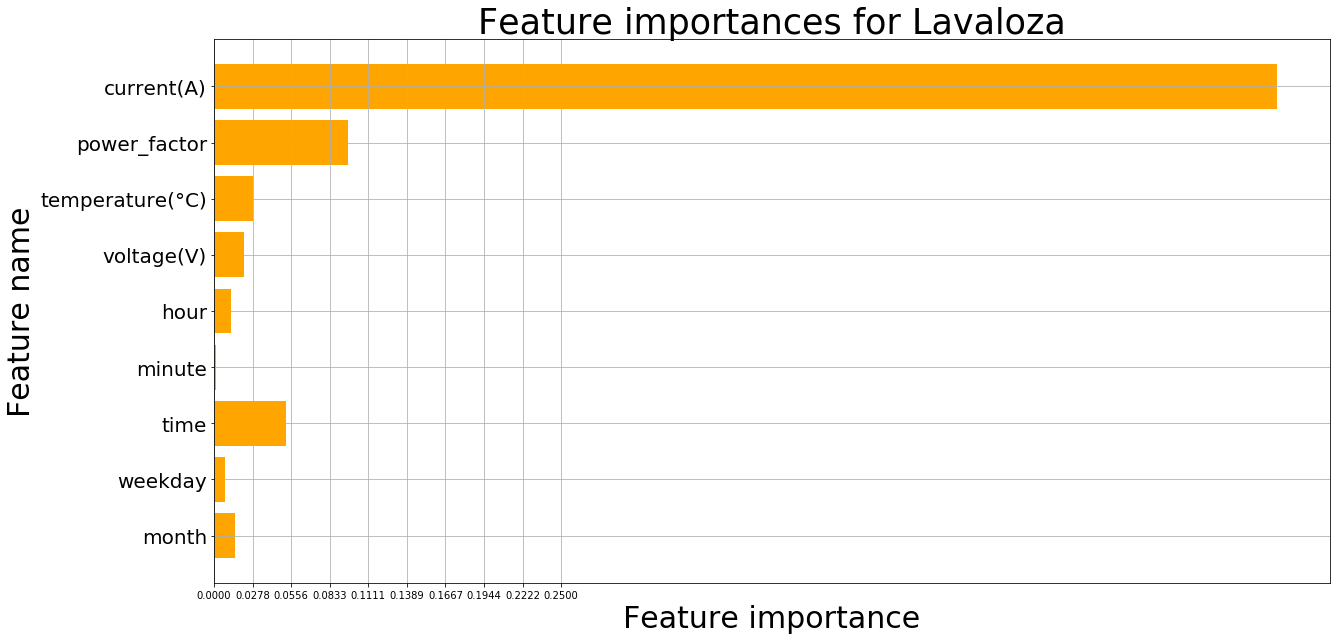

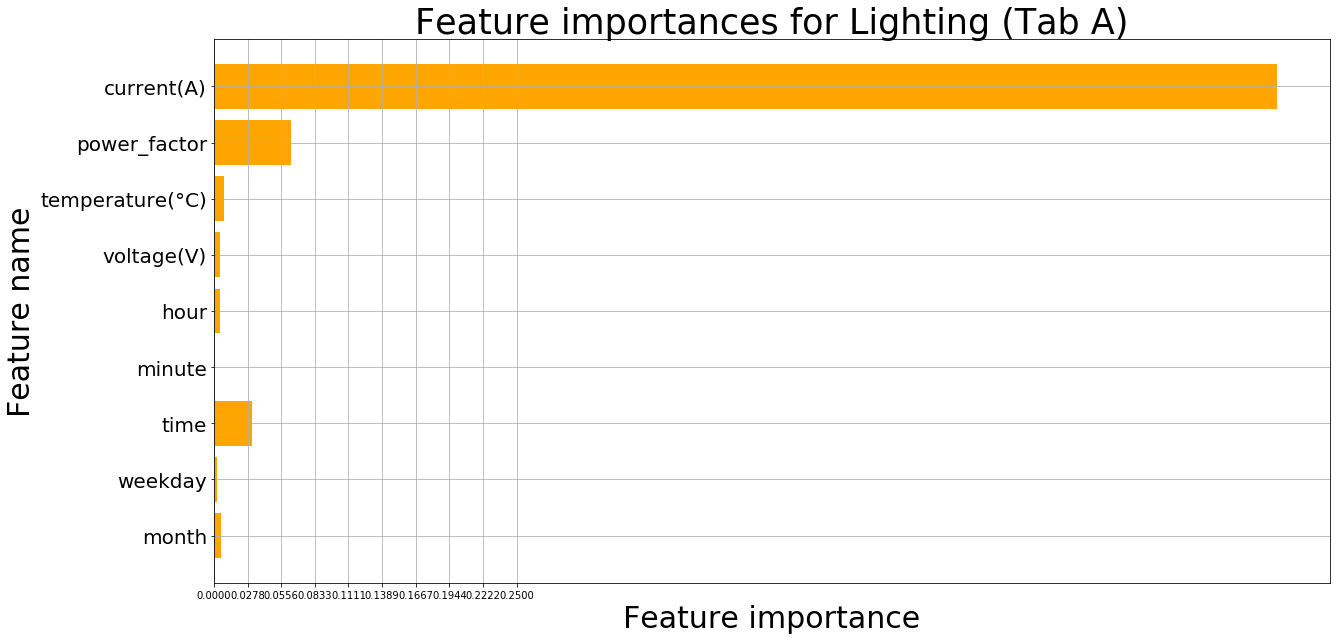

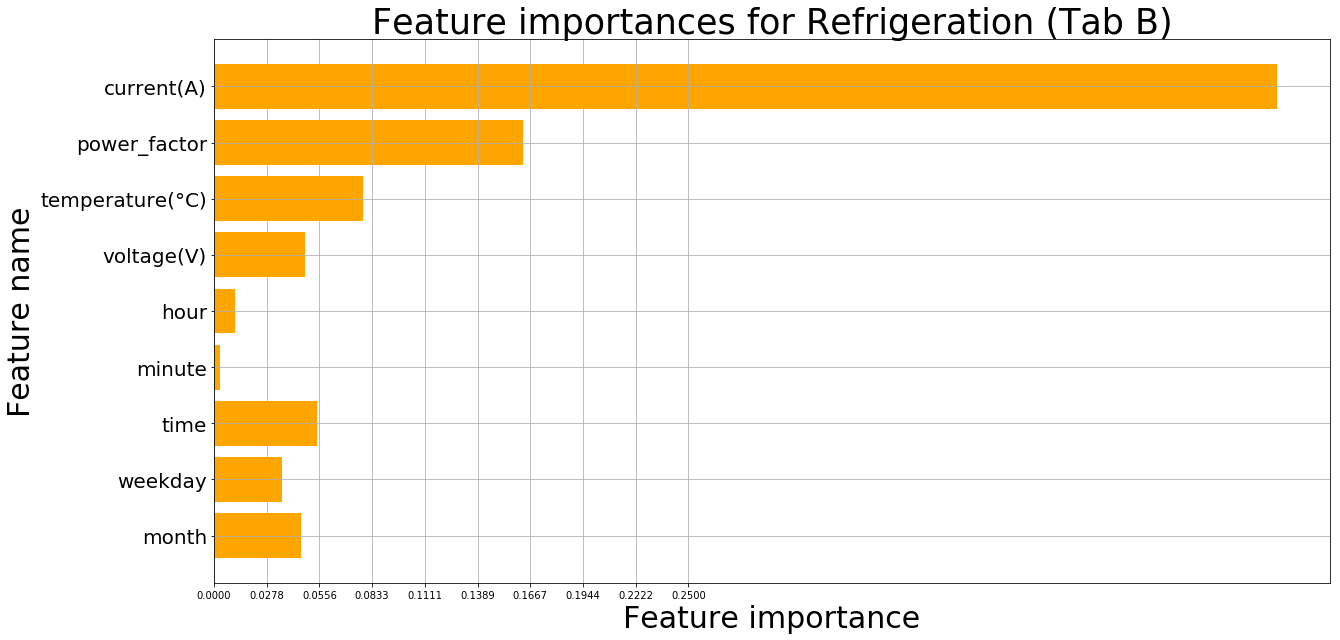

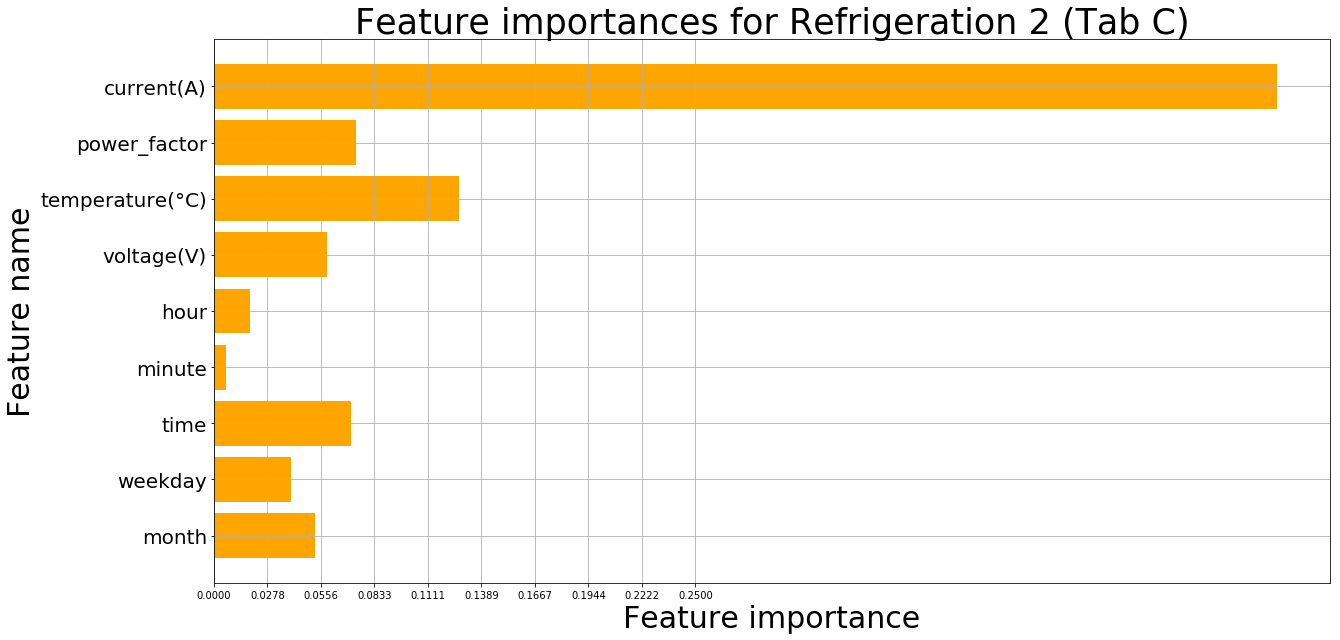

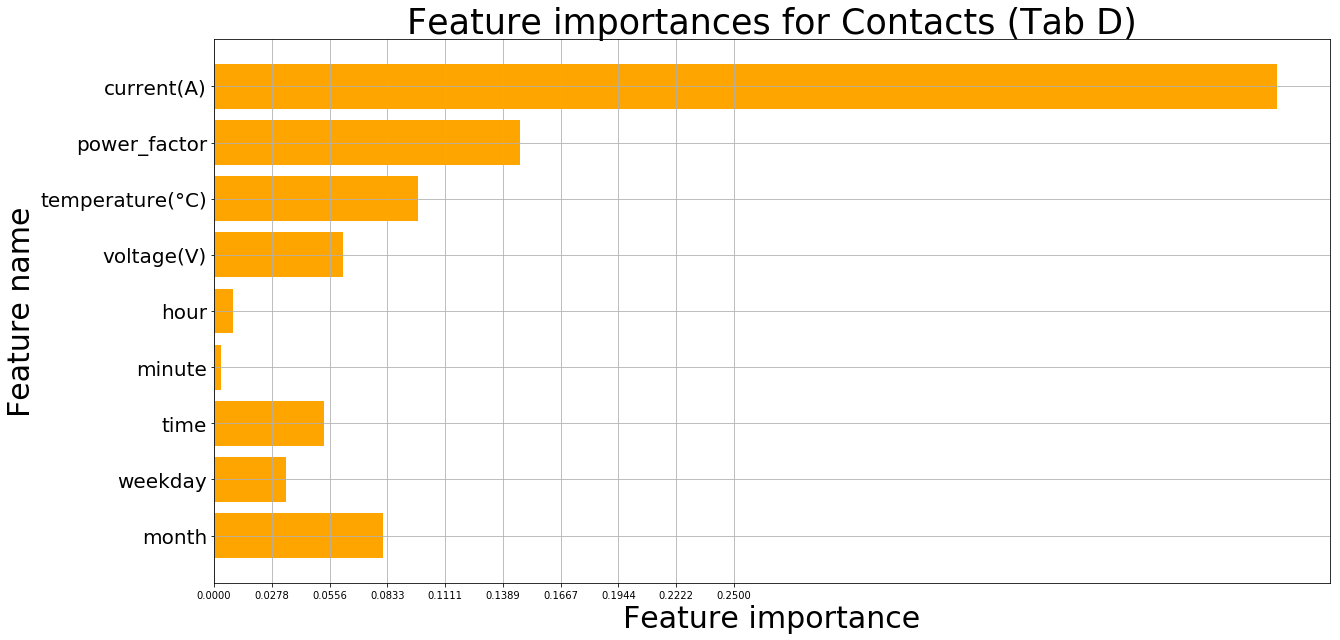

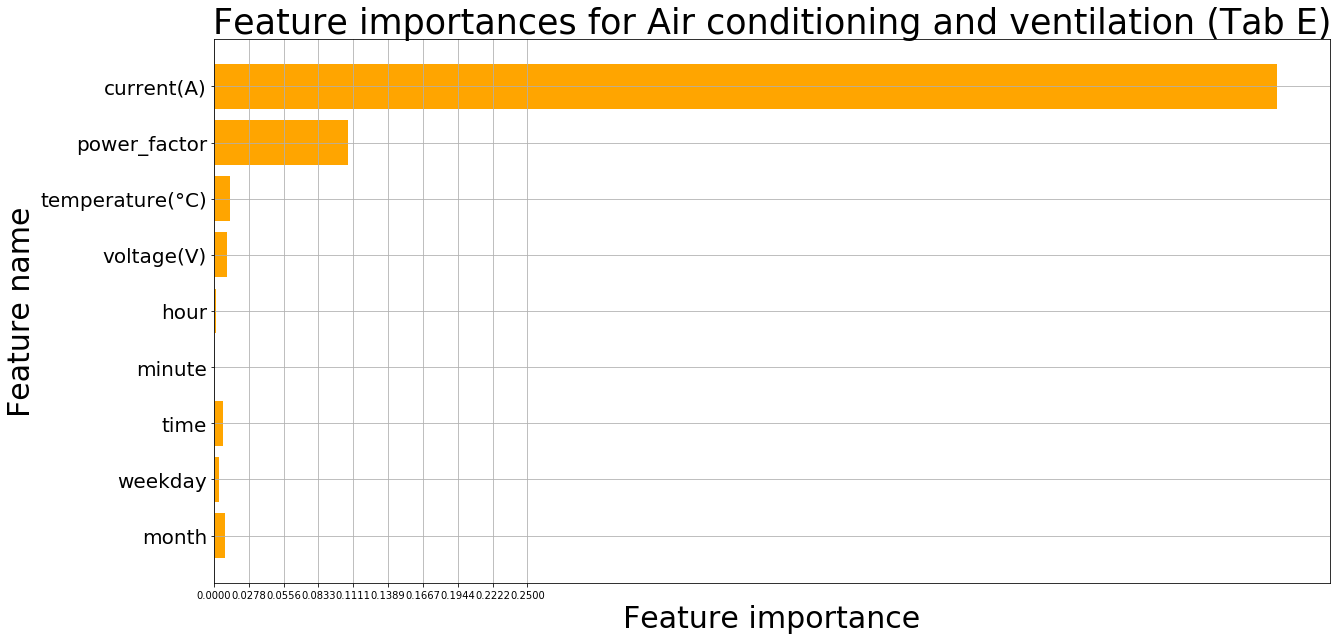

In [78]:
%matplotlib inline
for device, model in zip(devices_meaning, model_list_gbr):
    plot_feature_importances(device, model)
    

## Multilayer Perceptrons

In [66]:
param_grid = {'activation': ["relu", "tanh"],
              'hidden_layer_sizes': [[100], [100,100], [100,100,100]]
             }
grid = GridSearchCV(MLPRegressor(), param_grid, verbose=3, n_jobs = -1)

In [67]:
model_best_params_mlp = []

In [68]:
# Lavaloza
grid.fit(X_train_scaled, y_train["Lavaloza"].values.reshape(-1,1))
model_best_params_mlp.append(grid.best_params_)
print('The best parameters to use are: ', grid.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  18 | elapsed:  4.3min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  7.5min finished


The best parameters to use are:  {'activation': 'tanh', 'hidden_layer_sizes': [100, 100, 100]}


In [69]:
# Tablero A
grid.fit(X_train_scaled, y_train["Tablero A"].values.reshape(-1,1))
model_best_params_mlp.append(grid.best_params_)
print('The best parameters to use are: ', grid.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  18 | elapsed:  4.1min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  7.3min finished


The best parameters to use are:  {'activation': 'tanh', 'hidden_layer_sizes': [100, 100, 100]}


In [70]:
# Tablero B
grid.fit(X_train_scaled, y_train["Tablero B"].values.reshape(-1,1))
model_best_params_mlp.append(grid.best_params_)
print('The best parameters to use are: ', grid.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  18 | elapsed:  5.8min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  8.7min finished


The best parameters to use are:  {'activation': 'tanh', 'hidden_layer_sizes': [100, 100, 100]}


In [71]:
# Tablero C
grid.fit(X_train_scaled, y_train["Tablero C"].values.reshape(-1,1))
model_best_params_mlp.append(grid.best_params_)
print('The best parameters to use are: ', grid.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  18 | elapsed:  5.6min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  8.8min finished


The best parameters to use are:  {'activation': 'tanh', 'hidden_layer_sizes': [100, 100, 100]}


In [72]:
# Tablero D
grid.fit(X_train_scaled, y_train["Tablero D"].values.reshape(-1,1))
model_best_params_mlp.append(grid.best_params_)
print('The best parameters to use are: ', grid.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  18 | elapsed:  5.9min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  8.6min finished


The best parameters to use are:  {'activation': 'tanh', 'hidden_layer_sizes': [100, 100, 100]}


In [73]:
#Tablero E
grid.fit(X_train_scaled, y_train["Tablero E"].values.reshape(-1,1))
model_best_params_mlp.append(grid.best_params_)
print('The best parameters to use are: ', grid.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  18 | elapsed:  4.3min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  7.3min finished


The best parameters to use are:  {'activation': 'tanh', 'hidden_layer_sizes': [100, 100, 100]}


In [74]:
model_list_mlp= []
counter = 0
for column in y_train.columns:
    y = y_train[column].values.reshape(-1,1)
    mlp = MLPRegressor(activation = model_best_params_mlp[counter]["activation"],
                                    hidden_layer_sizes = model_best_params_mlp[counter]["hidden_layer_sizes"]).fit(X_train_scaled, y)
    model_list_mlp.append(mlp)
    counter += 1
    print("Model for {}".format(column))
    print(mlp.score(X_train_scaled, y_train[column].values.reshape(-1,1)))
    print(mlp.score(X_test_scaled, y_test[column].values.reshape(-1,1)))
    print("\n")

Model for Lavaloza
0.7875941512315989
0.7678888485333678


Model for Tablero A
0.9644502926051871
0.9597390672940306


Model for Tablero B
0.6167016892666015
0.5813742006942623


Model for Tablero C
0.6681780764756081
0.5745973136440363


Model for Tablero D
0.7056481445276216
0.6504772503092348


Model for Tablero E
0.9231549473898574
0.9207061758450231




# Create CSV

In [79]:
features_predict = scaler.transform(model_df[features])

for device, model_mlp, model_gbr in zip(devices_to_train, model_list_mlp, model_list_gbr):
    model_df[device + "_pred_mlp"] = model_mlp.predict(features_predict)
    model_df[device + "_pred_gbr"] = model_gbr.predict(features_predict)
model_df

,timestamp,device_name,current(A),power_factor,temperature(°C),voltage(V),hour,minute,time,weekday,...,Tablero A_pred_mlp,Tablero A_pred_gbr,Tablero B_pred_mlp,Tablero B_pred_gbr,Tablero C_pred_mlp,Tablero C_pred_gbr,Tablero D_pred_mlp,Tablero D_pred_gbr,Tablero E_pred_mlp,Tablero E_pred_gbr
0,2018-01-04 07:00:00,Interruptor Principal,36.43,0.95,12.00,127.0,7,0,7.00,3,...,1.130400,0.066984,26.319645,22.644755,2.293232,2.534149,1.407517,1.963527,1.540054,1.961908
1,2018-01-04 07:15:00,Interruptor Principal,37.57,0.95,12.00,127.0,7,15,7.25,3,...,2.124045,0.313282,24.068513,22.753055,2.716901,3.186931,1.503285,1.963527,1.700847,1.785990
2,2018-01-04 07:30:00,Interruptor Principal,31.58,0.95,12.00,127.0,7,30,7.50,3,...,1.250912,-0.105714,22.279974,21.449676,2.682183,2.494656,1.529582,2.005501,1.673304,1.827258
3,2018-01-04 07:45:00,Interruptor Principal,30.18,0.95,12.00,127.0,7,45,7.75,3,...,1.966912,0.840914,20.602609,20.150664,3.026874,2.557968,1.604592,1.904473,1.772020,2.030508
4,2018-01-04 11:00:00,Interruptor Principal,117.65,0.95,15.90,127.0,11,0,11.00,3,...,7.895068,7.108770,16.179798,15.156496,5.331859,4.881730,1.795561,2.383595,26.917804,30.667952
5,2018-01-04 11:15:00,Interruptor Principal,121.59,0.95,15.90,127.0,11,15,11.25,3,...,7.820774,7.490799,15.420489,14.815388,5.246698,5.082410,1.779254,2.383595,30.555163,37.493673
6,2018-01-04 11:30:00,Interruptor Principal,119.75,0.95,15.90,127.0,11,30,11.50,3,...,7.641965,7.233353,15.726757,14.592954,4.959433,5.088458,1.723962,2.385168,31.297756,34.509948
7,2018-01-04 11:45:00,Interruptor Principal,166.50,0.95,15.90,127.0,11,45,11.75,3,...,8.049280,6.939752,13.580242,14.685054,5.078979,5.112717,1.717675,4.371783,50.556478,48.661190
8,2018-01-04 12:00:00,Interruptor Principal,164.78,0.95,18.00,127.0,12,0,12.00,3,...,8.946161,8.350023,14.387431,12.630169,5.956788,5.457537,2.452536,3.347233,47.557414,54.791151
9,2018-01-04 12:15:00,Interruptor Principal,177.37,0.95,18.00,127.0,12,15,12.25,3,...,9.744428,9.547418,14.838962,14.011626,5.964486,5.583156,3.255670,4.123281,52.216302,57.048508


In [80]:
model_df.to_csv("predicciones.csv")